# import 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from time import time
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants 
from astropy.coordinates import SkyCoord
from astropy.visualization import hist
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
from astroML.crossmatch import crossmatch_angular

In [2]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr#

import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm

from collections import OrderedDict
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [3]:
#from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

In [4]:
def drop_index(data):
    data=data.reset_index(drop=True)
    return data

'''def drop_columns(data,column):
    data=data.drop(column,1)
    return data'''

In [5]:
from astropy.cosmology import FlatLambdaCDM,Planck13,Planck15,z_at_value
from astropy import units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
#cosmo=FlatLambdaCDM(H0=73,Om0=0.3)

## convert time

In [6]:
from astropy.time import Time
from astropy.io import fits
import time
import datetime
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates

def datetime2mjd(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    
    x=mdates.date2num(x)
    y = x - mjd_minus_mdates_num   
    return y

def mjd2datetime(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    y= x + mjd_minus_mdates_num
    y= mdates.num2date(y)
    return y



def datenums2mjd(x):
    #x=mdates.date2num(x)
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    y = x - mjd_minus_mdates_num   
    return y

def mjd2numsdate(x):
    mjd_ref=59000
    mjd_minus_mdates_num=mdates.date2num(convert_xaxis_time(mjd_ref))-mjd_ref
    
    y= x + mjd_minus_mdates_num
    #y= mdates.num2date(y)
    return y


def convert_xaxis_mjd(time):
    return Time(time).mjd   

def convert_xaxis_time(mjd):
    return Time(mjd,format='mjd').to_datetime()


def date2yday(x):
    """
    x is in matplotlib datenums, so they are floats.
    """
    y = x - mdates.date2num(datetime(2018, 1, 1))
    return y

def yday2date(x):
    """
    return a matplotlib datenum (x is days since start of year of 2018)
    """
    y = x + mdates.date2num(datetime(2018, 1, 1))
    return y


def convert_partial_year(numbers):
    datetimes=[]
    for number in numbers:
        year = int(number)
        d = timedelta(days=(number - year)*(365 + is_leap(year)))
        day_one = datetime(year,1,1)
        date = d + day_one
        datetimes.append(date)
    return datetimes


def is_leap(year):
    if not year%4 and  year%100 or not year%400:
        return True
    return False


def convert_mjd(times):
    timesmjd=[]
    for i in times:
        timesmjd.append(Time(i).mjd)
    return timesmjd  


def convert_date(times):
    timesdate=[]
    for i in times:
        timesdate.append(Time(i,format='mjd').datetime)
    return timesdate

def convert_date_single(time):
    timedate=Time(time,format='mjd').datetime
    return timedate

In [7]:
convert_xaxis_mjd(datetime.datetime(2005, 1, 1, 0, 0))

53371.0

In [8]:
convert_date_single(58000)

datetime.datetime(2017, 9, 4, 0, 0)

# load_timelag

In [9]:
#timelag_sources=pd.read_excel('/home/brettlv/Documents/timelag.xlsx',sheet_name='工作表2')
timelag_sources=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_lag/timelag_repair.xlsx',sheet_name='工作表2')
timelag_sources=timelag_sources[timelag_sources['select']==1.0]
timelag_sources=timelag_sources.reset_index(drop=True)
timelag_sources['Lbol11']=timelag_sources['Lbol']/10**11/(3.828e26*10**7)
timelag_sources['logLbol11']=np.log10(timelag_sources['Lbol11'])

In [10]:
for i in range(len(timelag_sources)):  
    if timelag_sources['type'][i].split(' ')[0]=='CLAGN':
        timelag_sources.loc[i,'color']='g'
        timelag_sources.loc[i,'label']='CLAGN'

    elif timelag_sources['type'][i].split(' ')[1]=='2':
        timelag_sources.loc[i,'color']='b'
        timelag_sources.loc[i,'label']='Type2'

    else:
        timelag_sources.loc[i,'color']='r'
        timelag_sources.loc[i,'label']='Type1'

In [11]:
timelag_sources_text=timelag_sources[timelag_sources['ref'].str.contains('Thiswork')]
timelag_sources_text=drop_index(timelag_sources_text)

In [12]:
timelag_sources_text

,Name,z,type,logmass,epoch,Lbol,Lsigma,band,refband,lag_lower,timelag,lag_upper,ref,bol_method,select,Lbol11,logLbol11,color,label
0,NGC1566,0.005017,CLAGN,6.9,NaN,3.120000e+43,6.640000e+42,W1,V,13.7,39.2,23.4,Thiswork,Lbol=9*L(5100A),1.0,0.081505,-1.088817,g,CLAGN


timelag_sources['OX']='O'

In [14]:
timelag_sources[timelag_sources['OX']=='O']

,Name,z,type,logmass,epoch,Lbol,Lsigma,band,refband,lag_lower,timelag,lag_upper,ref,bol_method,select,Lbol11,logLbol11,color,label,OX
0,NGC1566,0.005017,CLAGN,6.9,NaN,3.120000e+43,6.640000e+42,W1,V,13.7,39.2,23.4,Thiswork,Lbol=9*L(5100A),1.0,0.081505,-1.088817,g,CLAGN,O


## load_PG_quasars

In [15]:
timelag_PGQuasar=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_lag/timelag_repair.xlsx',sheet_name='PGquasars')

In [16]:
timelag_PGQuasar.columns

Index(['Name (1)', 'z (2)', 'Type (3)', 'LAGN,bol (4)', 'loge(s) (5)',
       'loge(t) (6)', 'DtW1,c2 (7)', 'AMPW1 (8)', 'DtW1,CCF (9)',
       'DtW2,c2 (10)', 'AMPW2 (11)', 'DtW2,CCF (12)', 'TagW1 (13)',
       'TagW (14)'],
      dtype='object')

In [17]:
for index,tau in enumerate(timelag_PGQuasar['DtW1,c2 (7)']):   
    tau_w1,e_tau_w1=tau.replace('','').split('±')
    timelag_PGQuasar.loc[index,'tau_w1']=float(tau_w1)
    timelag_PGQuasar.loc[index,'e_tau_w1']=float(e_tau_w1)   

In [18]:
timelag_PGQuasar[['LAGN,bol (4)','tau_w1','e_tau_w1']]

,"LAGN,bol (4)",tau_w1,e_tau_w1
0,13.3,1084.1,402.0
1,11.2,2607.5,288.3
2,11.9,280.0,41.0
3,12.4,557.2,41.4
4,13.0,2152.8,187.5
...,...,...,...
82,11.9,324.6,165.6
83,12.7,455.1,39.0
84,12.9,579.7,116.8
85,10.6,86.0,3.6


## load_S1

### Lyu19

In [19]:
timelag_19_Sy1=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_lag/timelag_repair.xlsx',sheet_name='Lyu2019_Sy1')
#timelag_19_Sy1=timelag_19_Sy1[timelag_19_Sy1['selet']==1.0]
#timelag_19_Sy1=drop_index(timelag_19_Sy1)

for i in range(len(timelag_19_Sy1)):  
    if timelag_19_Sy1['CLAGN'][i]=='CLAGN':
        timelag_19_Sy1.loc[i,'color']='r'
        timelag_19_Sy1.loc[i,'label']='CLAGN'
    else:
        timelag_19_Sy1.loc[i,'color']='b'
        timelag_19_Sy1.loc[i,'label']='Type1'

timelag_19_Sy1=timelag_19_Sy1[timelag_19_Sy1['selet']==1]
timelag_19_Sy1=timelag_19_Sy1.reset_index(drop=True)

#timelag_19_Sy1_text= timelag_19_Sy1[timelag_19_Sy1['CLAGN']=='CLAGN']
#timelag_19_Sy1_text=timelag_19_Sy1_text.reset_index(drop=True)




### Koshida14

In [20]:
timelag_14_Sy1=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_lag/timelag_repair.xlsx',sheet_name='14_Sy_lag')

timelag_14_Sy1_info=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_lag/timelag_repair.xlsx',sheet_name='Koshida14_Sy1')
timelag_14_Sy1_info['D_cm']=cosmo.luminosity_distance(timelag_14_Sy1_info['z']).to(u.cm).value
timelag_14_Sy1_info['D_pc']=cosmo.luminosity_distance(timelag_14_Sy1_info['z']).to(u.pc).value

for index,name in enumerate(timelag_14_Sy1['Object']):
    if isinstance(name, str):    #True    
        timelag_14_Sy1.loc[index,'Object']=timelag_14_Sy1.loc[index,'Object']
    else:
        timelag_14_Sy1.loc[index,'Object']=timelag_14_Sy1.loc[index-1,'Object']

###timelag_14_Sy1_WA

timelag_14_Sy1_WA=timelag_14_Sy1[timelag_14_Sy1['Sectiona']=='WA']
timelag_14_Sy1_WA=drop_index(timelag_14_Sy1_WA)

timelag_14_Sy1_WA['MV (mag)'][0].split(' ±')[0]

for index,i in enumerate(timelag_14_Sy1_WA['MV (mag)']):
    mv_i=float(i.split(' ±')[0].replace('−','-'))
    timelag_14_Sy1_WA.loc[index,'Mv']=mv_i

for index,i in enumerate(timelag_14_Sy1_WA['Δt bK(JAVELIN) (days)']):
    tau_i=float(i.split(' ± ')[0])
    e_tau_i=float(i.split(' ± ')[1])
    timelag_14_Sy1_WA.loc[index,'tau']=tau_i
    timelag_14_Sy1_WA.loc[index,'e_tau']=e_tau_i
    

timelag_14_Sy1_WA.columns

timelag_14_Sy1_WA['m_v']=timelag_14_Sy1_WA['Mv']+5*np.log10(timelag_14_Sy1_info['D_pc']/10)
timelag_14_Sy1_WA['logLbol']=np.log10(9)+(-48.6-timelag_14_Sy1_WA['m_v'])/2.5+np.log10(4*np.pi*timelag_14_Sy1_info['D_cm']**2)+np.log10((constants.c/(5100*u.AA)).to(u.Hz).value)
timelag_14_Sy1_WA['logLbol_sol']=timelag_14_Sy1_WA['logLbol']-np.log10(3.828e26*10**7)
timelag_14_Sy1_WA['CLAGN']=timelag_14_Sy1_info['CLAGN']
timelag_14_Sy1_WA['OX']=timelag_14_Sy1_info['OX']

for i in range(len(timelag_14_Sy1_WA)):  
    if timelag_14_Sy1_WA['CLAGN'][i]=='CLAGN':
        timelag_14_Sy1_WA.loc[i,'color']='r'
        timelag_14_Sy1_WA.loc[i,'label']='CLAGN'
    else:
        timelag_14_Sy1_WA.loc[i,'color']='b'
        timelag_14_Sy1_WA.loc[i,'label']='Type1'



timelag_14_Sy1_WA_text=timelag_14_Sy1_WA[timelag_14_Sy1_WA['CLAGN']=='CLAGN']
timelag_14_Sy1_WA_text=timelag_14_Sy1_WA_text.reset_index(drop=True)


timelag_14_Sy1_WA_text_1=timelag_14_Sy1_WA[timelag_14_Sy1_WA['Object']=='Mrk 590']
timelag_14_Sy1_WA_text_1=timelag_14_Sy1_WA_text_1.reset_index(drop=True)

In [21]:
timelag_14_Sy1_WA

,Object,Sectiona,Unnamed: 2,MJD,MV (mag),Δt bK(CCF) (days),Δt cK(CCF) (days),Δt bK(JAVELIN) (days),ΔtK(JAVELIN)c (days),Mv,tau,e_tau,m_v,logLbol,logLbol_sol,CLAGN,OX,color,label
0,Mrk 335,WA,NaN,...,−20.63 ± 0.02,142.2 ± 16.7,132.1 ± 15.8,167.1 ± 5.6,165.8 ± 6.7,-20.63,167.1,5.6,14.629314,44.613404,11.030432,NaN,NaN,b,Type1
1,Mrk 590,WA,NaN,...,−18.69 ± 0.08,37.2 ± 2.7,35.9 ± 2.7,33.8 ± 4.2,32.2 ± 4.0,-18.69,33.8,4.2,16.620207,43.837404,10.254432,CLAGN,O,r,CLAGN
2,IRAS 03450+0055,WA,NaN,...,−21.41 ± 0.02,108.2 ± 4.8,92.0 ± 4.5,158.3 ± 5.4,152.5 ± 7.1,-21.41,158.3,5.4,14.227573,44.925404,11.342432,NaN,NaN,b,Type1
3,Akn 120,WA,NaN,...,−22.23 ± 0.02,138.8 ± 17.5,127.6 ± 15.2,140.9 ± 17.2,129.7 ± 18.0,-22.23,140.9,17.2,13.527710,45.253404,11.670432,NaN,NaN,b,Type1
4,MCG +08-11-011,WA,NaN,...,−20.25 ± 0.06,95.8 ± 13.8,86.4 ± 12.7,73.5 ± 1.4,69.9 ± 2.1,-20.25,73.5,1.4,14.501365,44.461404,10.878432,NaN,NaN,b,Type1
5,Mrk 79,WA,NaN,...,−19.98 ± 0.04,74.0 ± 3.6,67.0 ± 2.6,65.6 ± 5.0,71.8 ± 4.2,-19.98,65.6,5.0,14.947133,44.353404,10.770432,NaN,NaN,b,Type1
6,Mrk 110,WA,NaN,...,−20.63 ± 0.04,90.3 ± 6.1,84.3 ± 5.8,119.7 ± 5.5,106.8 ± 8.0,-20.63,119.7,5.5,15.325375,44.613404,11.030432,NaN,NaN,b,Type1
7,NGC 3227,WA,NaN,...,−17.06 ± 0.06,14.5 ± 0.6,13.3 ± 0.6,14.6 ± 0.7,13.8 ± 0.7,-17.06,14.6,0.7,14.060481,43.185404,9.602432,NaN,NaN,b,Type1
8,NGC 3516,WA,NaN,...,−18.14 ± 0.09,52.9 ± 9.5,47.3 ± 9.9,73.1 ± 4.0,71.5 ± 5.8,-18.14,73.1,4.0,14.601399,43.617404,10.034432,CLAGN,O,r,CLAGN
9,Mrk 744,WA,NaN,...,−16.12 ± 0.05,20.4 ± 2.1,19.2 ± 1.9,20.0 ± 2.2,19.7 ± 2.2,-16.12,20.0,2.2,17.055318,42.809404,9.226432,NaN,NaN,b,Type1


# tau-L

In [22]:
png_dir='/Volumes/ExtremeSSD/CLAGN_statistic_plot/'

-1.088817335086363 39.2 -0.006918714898942609 [[13.7], [23.4]]


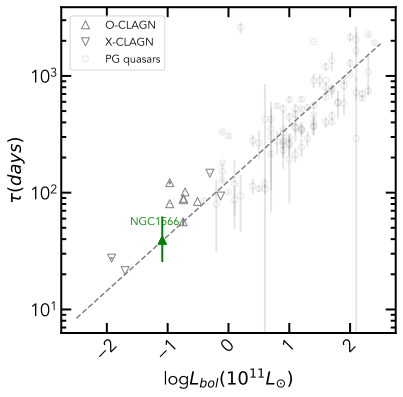

In [24]:
from adjustText import adjust_text

fig = plt.figure(figsize=(6, 6))
#fig.subplots_adjust(left=0.1, right=0.85, bottom=0.12, top=0.95)
ax=fig.add_subplot(1,1,1)
#ax.set_title('NGC1566_V')


Lagnrange=np.logspace(-2.5,2.5)
tau_Lagn= (Lagnrange)**(0.47)*10**2.1

tau_Lagn_slope5= (Lagnrange)**(0.5)*10**2.1



for i in range(len(timelag_19_Sy1)):
    if timelag_19_Sy1['OX'][i]=='O':
        color='grey'
        label='O-CLAGN'
        marker='^'
    elif timelag_19_Sy1['OX'][i]=='X':
        color='grey'
        label='X-CLAGN'
        marker='v'
    x=timelag_19_Sy1['log(LAGN,bol L) (V-band) '][i]-11
    y=timelag_19_Sy1['Dt day–1'][i]/0.6  
    
    if timelag_19_Sy1['CLAGN'][i]=='CLAGN':
        ax.errorbar(x,y,ms=8., mew=1, capsize=0,mec=color,ecolor=color,
            elinewidth=2,ls='',fillstyle='none',marker=marker,label=label)
    
'''texts = [ax.text(timelag_19_Sy1_text['log(LAGN,bol L) (V-band) '][i]-11, 
                 timelag_19_Sy1_text['Dt day–1'][i] ,
                 timelag_19_Sy1_text['Name'][i]+'_Lyu19',
                 fontsize=9,color=timelag_19_Sy1_text['color'][i]) for i in range(len(timelag_19_Sy1_text))]

adjust_text(texts,ax=ax,#arrowprops=dict(arrowstyle='->', color='red',lw=0.5),
            expand_text=(1.5,1.3),
            expand_points=(1.5,1.3),
            expand_objects=(1.5, 1.3),
            expand_align=(1.5, 1.3),
            autoalign='xy',
           #only_move={'points':'x', 'text':'x'}
           ) #使用adjust_text
'''################################################################ 



for i in range(len(timelag_14_Sy1_WA)):
    if timelag_14_Sy1_WA['OX'][i]=='O':
        color='grey'
        label='O-CLAGN'
        marker='^'
    elif timelag_14_Sy1_WA['OX'][i]=='X':
        color='grey'
        label='X-CLAGN'
        marker='v'
    x=timelag_14_Sy1_WA['logLbol_sol'][i]-11
    y=timelag_14_Sy1_WA['tau'][i]/0.6    
    yerr=timelag_14_Sy1_WA['e_tau'][i] 
    if timelag_14_Sy1_WA['CLAGN'][i]=='CLAGN':
        ax.errorbar(x,y,yerr=yerr,ms=8,capsize=0,mec=color,ecolor=color,elinewidth=2,
                ls='',fillstyle='none',marker=marker,label=label)

'''
    
texts = [ax.text(timelag_14_Sy1_WA_text['logLbol_sol'][i]-11, 
                 timelag_14_Sy1_WA_text['tau'][i] ,
                 timelag_14_Sy1_WA_text['Object'][i]+'_14',
                 fontsize=9,color=timelag_14_Sy1_WA_text['color'][i]) for i in range(len(timelag_14_Sy1_WA_text))]

adjust_text(texts,ax=ax,#arrowprops=dict(arrowstyle='->', color='red',lw=0.5),
            expand_text=(1.5,1.3),
            expand_points=(1.5,1.3),
            expand_objects=(1.5, 1.3),
            expand_align=(1.5, 1.3),
            autoalign='xy',
           #only_move={'points':'x', 'text':'x'}
           ) #使用adjust_text

 '''   
    
################################################################    
        
for i in range(len(timelag_sources)):
    
    if timelag_sources['type'][i].split(' ')[0]=='CLAGN':
        if timelag_sources['ref'][i]=='Thiswork':        
            color='g'
        else:
            color='grey'
            
        if timelag_sources['OX'][i]=='O':      
            label='O-CLAGN'
            marker='^'
        elif timelag_sources['OX'][i]=='X':   
            label='X-CLAGN'
            marker='v'            
        

    
    x=timelag_sources.loc[i,'logLbol11']
    y=timelag_sources.loc[i,'timelag']
        
    if timelag_sources['lag_lower'][i]>0:      
        asym_yerr=[[timelag_sources['lag_lower'][i]],[timelag_sources['lag_upper'][i]]]
        
    else:
        asym_yerr=0
        
    if timelag_sources['Lsigma'][i]>0: 
            #print(i,timelag_sources['Name'][i],x,y,yerr[0],yerr[1],y-yerr[0],y+yerr[1])             
            xerr= timelag_sources['Lsigma'][i]/10**11/(3.828e26*10**7)/x/np.log(10)                   
            #print('L_range',x,xmax)
    else: 
        xerr=0
        
    print(x,y,xerr,asym_yerr) 

    ax.errorbar(x,y,xerr=xerr,yerr=asym_yerr,ms=8,capsize=0,mec=color,ecolor=color,elinewidth=2,
                ls='',fillstyle='none',marker=marker)
            #ax.vlines(x,ymin=y-yerr[0],ymax=y+yerr[1],color=color,linewidth=2,ls='-',zorder=1)
            #ax.hlines(y,timelag_sources['logLbol11'][i],xmax,color=color,linewidth=2,ls='-',zorder=1)           
            
ax.errorbar(timelag_sources_text['logLbol11'],timelag_sources_text['timelag'],
            ms=8., mew=1, color='g',
            elinewidth=2,fmt='s',ls='',
            #fillstyle='none',
            marker='^',zorder=2)
        
texts = [ax.text(timelag_sources_text['logLbol11'][i]-0.6, timelag_sources_text['timelag'][i]+10,
         timelag_sources_text['Name'][i],fontsize=11,
         color=timelag_sources_text['color'][i]) for i in range(len(timelag_sources_text))]

adjust_text(texts,ax=ax,#arrowprops=dict(arrowstyle='->', color='red',lw=0.5),
            expand_text=(1.3,1.2),
            expand_points=(1.5,1.2),
            expand_objects=(1.5, 1.2),
            expand_align=(1.5, 1.2),
            autoalign='xy',
           #only_move={'points':'x', 'text':'x'}
           ) #使用adjust_text


################################################################################### 
ax.errorbar(np.log10(Lagnrange),tau_Lagn,ls='--',label='PG quasars',color='grey',zorder=0) 
#ax.errorbar(np.log10(Lagnrange),tau_Lagn_slope5,ls='-.',label='',color='cyan',zorder=0) 



#timelag_PGQuasar[['LAGN,bol (4)','tau_w1','e_tau_w1']]
ax.errorbar(x=timelag_PGQuasar['LAGN,bol (4)']-11,
            y=timelag_PGQuasar['tau_w1'],yerr=timelag_PGQuasar['e_tau_w1'],
            marker='o',ms=6., mew=1, capsize=0,mec='grey',ecolor='grey',
            elinewidth=2,fmt='o',ls='',fillstyle='none',
            label='PG quasars',color='grey',alpha=0.2,zorder=0) 

################################################################################################ 
set_ax_tick(ax)

#ax.set_xlim(timerangel,timeranger)
#ax.set_xlim(-2.5,2.5)
#ax.set_ylim(20,300)

ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl = [h[0] for h in handles]
labels_dict=dict(zip(labels, hdl)) #key,values

by_label = OrderedDict(zip(labels, hdl)) 
#by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

# use them in the legend
#by_label = OrderedDict(zip(labels, handles)) 
#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),loc=2, numpoints=1, fontsize=11. )


ax.semilogy()
#ax.semilogx()
#ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1000))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
#plt.title(r'$\tau$- $L_{bol}$')        
ax.set_ylabel(r'$\tau(days)$')
ax.set_xlabel(r'log$L_{bol}(10^{11}L_{\odot})$')
fig.savefig('%s/tau_L_correlation.png'%png_dir,dpi=400,transparent=False,bbox_inches='tight')

In [ ]:
timelag_sources_text

In [ ]:
timelag_19_Sy1_text

In [ ]:
timelag_14_Sy1_info_text

# lightcurve

## CLAGN_wiselc_list

In [ ]:
CLAGN_210919=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_list210919.xlsx',sheet_name='Sheet1')

In [ ]:
CLAGN_wiselc_list=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_list210919.xlsx',sheet_name='Sheet2')

In [ ]:
CLAGN_wiselc_list

In [ ]:
181%180

In [ ]:
182//180

In [ ]:
371//180

$$w_i=\frac{\frac{1}{m_i}}{\sum{\frac{1}{m_i}}} $$

$$w_i=\frac{{f_i}}{\sum{{f_i}}} $$